In [40]:
%load_ext autoreload
%autoreload 2

import sys
import os

from typing import Dict, List
import json
from my_trace import TraceBank
import benchmark as bm

scrape = bm.TraceScrape()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Obtaining Run from nexus-writer
Obtaining Frame from digitiser-aggregator
Obtaining process_kafka_message from trace-to-events
Obtaining run_schedule from simulator


In [41]:
runs = scrape.get_last_n_runs(1)

Next Run


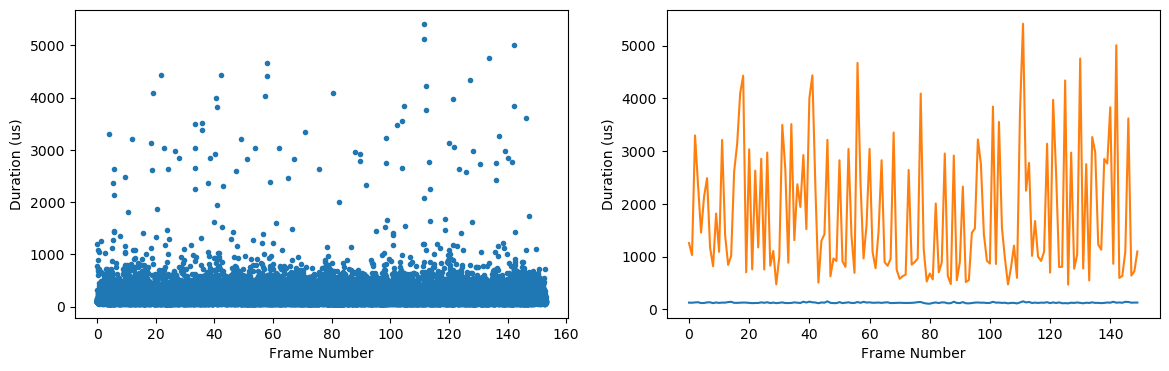

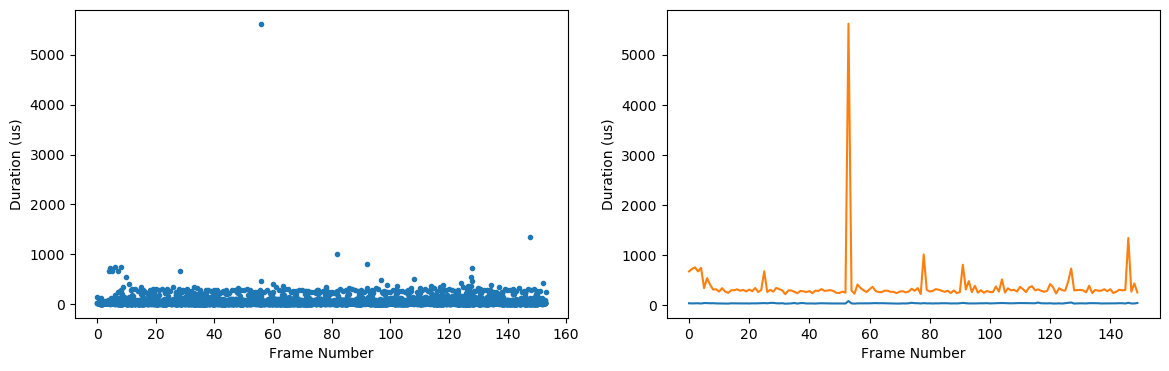

In [42]:
for run in runs:
    print("Next Run")
    bm.plot(run)